### Initially just some playing round with Keras

Input: Image<br>
Initial output: center of hand<br>
Is anchors needed? So the prediction is an offset?<br>


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Conv2D, Conv3D, Reshape, Dense, Flatten, Concatenate, concatenate
from keras.initializers import TruncatedNormal
from keras.regularizers import l2
from keras.callbacks import Callback
from keras import optimizers
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from SqueezeDetHelpers import fire_layer

In [4]:
print(tf.__version__)

1.12.0


- Grid over image size
    - Grid nodes will be anchors
    - Net predicts: Probability of class at anchor, and offset from anchor.
        - In later versions, several offsets will be predicted at each offset.
- The net is fully convolutional, meaning the output must be feature maps.
    - Amount of output filters will then be confidence+x_offset+y_offset
    - filter size will be the size of the anchor grid

In [5]:
num_out = 3

In [6]:
DATA_DIR = r"./data"
ANNOTATION_FILE = r"annot"
annotation = os.path.join(DATA_DIR, ANNOTATION_FILE)
print(annotation)

./data/annot


In [7]:
EPSILON = 1e-16

In [8]:
BATCHSIZE = 8

In [9]:
HEIGHT = 320
WIDTH = 320
CHANNELS = 3

In [10]:
WEIGHT_DECAY = 0.001
CLASSES = 1

In [11]:
ANCHOR_HEIGHT = 80
ANCHOR_WIDTH = 80

In [12]:
num_anchor_nodes = ANCHOR_HEIGHT * ANCHOR_WIDTH

print(f"Out dim: {ANCHOR_HEIGHT}x{ANCHOR_WIDTH}")
print(f"Number of anchor nodes: {num_anchor_nodes}")

Out dim: 80x80
Number of anchor nodes: 6400


In [13]:
def set_anchors():
    
    #anchors = np.zeros((num_anchor_nodes, 2))
    anchors = np.zeros((ANCHOR_HEIGHT, ANCHOR_WIDTH, 2), dtype=np.uint32)
    print(f"Number of anchors: {num_anchor_nodes}")
    
    print(f"Anchor dimension: ({ANCHOR_HEIGHT}, {ANCHOR_WIDTH})")
    print(f"Anchor shape: {anchors.shape}")
    
    #xs = np.arange(PIXELS_BETWEEN_ANCHORS, WIDTH, PIXELS_BETWEEN_ANCHORS)
    #ys = np.arange(PIXELS_BETWEEN_ANCHORS, HEIGHT, PIXELS_BETWEEN_ANCHORS)
    
    x_start = WIDTH / (ANCHOR_WIDTH + 1)
    x_end = WIDTH - x_start
    y_start = HEIGHT / (ANCHOR_HEIGHT + 1)
    y_end = HEIGHT - y_start
    xs = np.linspace(x_start, x_end, num=ANCHOR_WIDTH, dtype=np.uint32)
    ys = np.linspace(y_start, y_end, num=ANCHOR_HEIGHT, dtype=np.uint32)
    
    """
    counter = 0
    for cx in range(len(xs)):
        for cy in range(len(ys)):
            anchors[counter] = [xs[cx], ys[cy]]
            counter += 1
    """
    
    for ix in range(ANCHOR_HEIGHT):
        for iy in range(ANCHOR_WIDTH):
            anchors[ix, iy] = (xs[ix], ys[iy])
    
    return anchors
    
anchs = set_anchors()
anchs[2, 2]

Number of anchors: 6400
Anchor dimension: (80, 80)
Anchor shape: (80, 80, 2)


array([11, 11], dtype=uint32)

In [14]:
input_layer = Input(shape=(HEIGHT, WIDTH, CHANNELS), name="input")
print(f"input: {input_layer.shape}")

conv1 = Conv2D(name='conv1', filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding="SAME",
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY))
               )(input_layer)
print(f"conv1: {conv1.shape}")

conv2 = Conv2D(name='conv2', filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="SAME",
               #filters=len(ANCHORS),
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY)
               )(conv1)
print(f"conv2: {conv2.shape}")

conv3 = Conv2D(name='conv3', filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="SAME",
               #filters=len(ANCHORS),
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY)
               )(conv2)
print(f"conv3: {conv3.shape}")

conv4 = Conv2D(name='conv4', filters=256, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding="SAME",
               #filters=len(ANCHORS),
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY)
               )(conv3)
print(f"conv4: {conv4.shape}")

preds = Conv2D(name='preds', filters=num_out, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid', padding="SAME",
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY)
               )(conv4)
print(f"preds: {preds.shape}")

"""
pred_conf = Conv2D(name='pred_conf', filters=1, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid', padding="SAME",
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY)
               )(conv4)
print(f"pred_conf: {pred_conf.shape}")

pred_offset = Conv2D(name='pred_offset', filters=2, kernel_size=(1, 1), strides=(1, 1), activation=None, padding="SAME",
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY)
               )(conv4)
print(f"pred_offset: {pred_offset.shape}")

#preds = Concatenate()([pred_conf, pred_offset])
preds = concatenate([pred_conf, pred_offset])
print(f"preds: {preds.shape}")
"""

#pred_reshaped = Reshape((-1, 1))(preds)
#print(pred_reshaped.shape)
"""
flat = Flatten()(conv2)

dense1 = Dense(256,
               name='dense1',
               activation='relu')(flat)
print(dense1.shape)

out = Dense(2,
            name='out',
            activation='sigmoid')(flat)
print(out.shape)
"""

input: (?, 320, 320, 3)
conv1: (?, 160, 160, 32)
conv2: (?, 160, 160, 64)
conv3: (?, 160, 160, 128)
conv4: (?, 80, 80, 256)
preds: (?, 80, 80, 3)


"\nflat = Flatten()(conv2)\n\ndense1 = Dense(256,\n               name='dense1',\n               activation='relu')(flat)\nprint(dense1.shape)\n\nout = Dense(2,\n            name='out',\n            activation='sigmoid')(flat)\nprint(out.shape)\n"

cross-entropy: q * -log(p) + (1-q) * -log(1-p)

In [35]:
def loss(y_true, y_pred):
    # We are predicting a batchsize x anchorwidth x anchorheight x 3 output.
    c_predictions = y_pred[:, :, :, 0]
    c_labels = y_true[:, :, :, 0]
    
    y_pred_offset = y_pred[:, :, :, 1:]
    y_true_offset = y_true[:, :, :, 1:]
    
    #pred_conf = K.sigmoid(c_predictions)
    #pred_conf = c_predictions

    #c_loss = K.sum(
    #    -(c_labels * K.log(pred_conf + EPSILON) + (1-c_labels) * K.log(1-pred_conf + EPSILON))
    #) / BATCHSIZE
    
    c_loss = K.sum(
        c_labels * (-K.log(c_predictions + EPSILON)) + (1-c_labels) * (-K.log(1-c_predictions + EPSILON))
    ) / BATCHSIZE
    
    #c_loss = K.sum(
    #    K.maximum(K.abs(c_predictions), 0) - c_predictions * c_labels + K.log(1 + K.exp(-K.abs(c_predictions)))
    #) / BATCHSIZE
    
    #c_loss = K.sum(
    #    K.maximum(K.abs(c_predictions), 0) - c_predictions * c_labels + K.log(1 + K.exp(-K.abs(c_predictions)))
    #, axis=0) / BATCHSIZE

    #c_loss = K.sum(c_loss) / (ANCHOR_HEIGHT * ANCHOR_WIDTH)
    
    #diff = K.abs(c_labels - c_predictions)
    #c_loss = 2 * (K.sigmoid(diff) - 0.5)
    
    #c_loss = K.sum(
    #    K.sigmoid(
    #        K.abs(
    #            c_labels - c_predictions
    #        )
    #    )
    #) / BATCHSIZE
    
    #c_loss = K.sum(
    #    2 * K.sigmoid(
    #        K.abs(
    #            c_labels - c_predictions
    #        )
    #    ) - 0.5
    #) / BATCHSIZE
    
    #c_loss = K.sum(
    #    K.abs(
    #        c_labels - c_predictions
    #    )
    #)
    
    
    #c_loss = K.sig
    
    #l2_loss = K.sum(
    #    K.pow(y_pred_offset - y_true_offset, 2)
    #) / BATCHSIZE
    
    #l2_loss = K.sum(
    #    2 * K.sigmoid (
    #        K.sqrt(
    #            K.pow(y_true_offset[0] - y_true_offset[0], 2) + K.pow(y_true_offset[1] - y_pred_offset[1], 2)
    #        )
    #    ) - 0.5
    #) / BATCHSIZE
    
    #l2_loss = K.sum(
    #    2 * K.sigmoid(
    #        K.pow(y_pred_offset - y_true_offset, 2)
    #    ) - 0.5
    #) / BATCHSIZE
    
    
    l2_loss = 0
    
    total_loss = c_loss + l2_loss
    
    return total_loss

#y_true_test = np.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
#y_pred_test = np.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
#l = loss(y_pred_test, y_true_test)
#print(l)

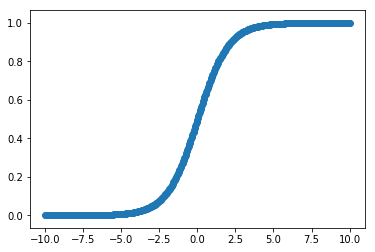

In [16]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

x = np.linspace(-10, 10, 500)
y = sigmoid(x)
plt.scatter(x, y)

$−(ylog(p)+(1−y)log(1−p))$

https://stackoverflow.com/questions/48951109/keras-custom-binary-cross-entropy-loss-function-get-nan-as-output-for-loss<br>
$max(x, 0) - x * z + log(1 + exp(-abs(x)))$<br>
$max(p, 0) - p * y + log(1 + exp(-abs(p)))$

In [17]:
c_labels = 1
pred_conf = 0

diff = abs(c_labels - pred_conf)
l = (sigmoid(diff) - 0.5) * 2
#print(l)

#pred_conf = sigmoid(pred_conf)
#ll = -(c_labels * np.log(pred_conf + EPSILON) + (1 - c_labels) * np.log(1-pred_conf + EPSILON))
#print(ll)

lll = np.max(np.abs(pred_conf), 0) - pred_conf * c_labels + np.log(1 + np.exp(-np.abs(pred_conf)))
print(lll)

0.6931471805599453


In [18]:
y_t = np.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
y_t[:, 10, 10, 0] = 1.0
print(y_t.shape)
#np.max(np.maximum(-y_t, 0))
np.sum(y_t) / BATCHSIZE

(8, 80, 80, 3)


1.0

In [19]:
#sess = tf.InteractiveSession()

"""
with tf.Session() as s:
    # Some tensor we want to print the value of
    y_true_test = tf.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
    y_pred_test = tf.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
    s.run(tf.global_variables_initializer())
    
    l = loss(y_pred_test, y_true_test)
    # Add print operation
    print(s.run(l))
"""

'\nwith tf.Session() as s:\n    # Some tensor we want to print the value of\n    y_true_test = tf.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))\n    y_pred_test = tf.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))\n    s.run(tf.global_variables_initializer())\n    \n    l = loss(y_pred_test, y_true_test)\n    # Add print operation\n    print(s.run(l))\n'

In [20]:
c_labels = 0
c_predictions = 1
c_loss = (c_labels * (-np.log(c_predictions + EPSILON))) + (1-c_labels) * (-np.log(1-c_predictions + EPSILON))
print(c_loss)

36.841361487904734


In [21]:
#model = Model(inputs=input_layer, outputs=preds)
#model.compile(loss='mse', optimizer='adam')
#model.compile(loss=loss, optimizer='adam')

In [22]:
def load_data():
    
    with open(annotation, 'r') as f:
        lines = f.readlines()
    
    gt = [(None, None)] * len(lines)
    
    for l in lines:
        obj = l.split(',')
        pic_id = int(obj[0].split('.')[0])
        x = int(obj[1])
        y = int(obj[2])
        
        gt[pic_id] = (x, y)

    images = []
    
    for fi in os.listdir(DATA_DIR):
        if not fi.endswith('jpg'):
            continue
        im = cv2.imread(os.path.join(DATA_DIR, fi))
        images.append(im)
    
    return gt, images

labels_old, images_old = load_data()

In [23]:
def closest_anchor_map(x, y, anchor_coords):
    """ Create a anchor_height x anchor_width x 3 map.
        First entry is 1 if the anchor point is closest to true point. Zero otherwise.
        Second is x offset.
        Third is y offset. """
    closest = 10000
    closest_x = None
    closest_y = None
    closest_x_offset = None
    closest_y_offset = None
    
    res = np.zeros((ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
    for ix in range(ANCHOR_HEIGHT):
        for iy in range(ANCHOR_WIDTH):
            p_x, p_y = anchor_coords[ix, iy]
            dist = np.sqrt( (x - p_x)**2 + (y - p_y)**2 )
            #res[ix, iy, 1:] = (x - p_x, y - p_y)
            if dist < closest:
                closest = dist
                closest_x = ix
                closest_y = iy
                closest_x_offset = x - p_x
                closest_y_offset = y - p_y
    
    #print(f"({closest_x}, {closest_y}) -> {anchor_coords[closest_x, closest_y]}")
    res[closest_x, closest_y, 0] = 1
    res[closest_x, closest_y, 1:] = (closest_x_offset, closest_y_offset)
    
    return res
        
test_map = closest_anchor_map(20, 30, anchs)
print(test_map.shape)
print(np.count_nonzero(test_map[:,:, 0]))
print(np.mean(test_map[:, :, 1]))
print(np.mean(test_map[:, :, 2]))
anc_indicies = np.where(test_map[:, :, 0] == test_map[:, :, 0].max())
print(test_map[anc_indicies[0], anc_indicies[1]])
anchor_point = test_map[anc_indicies[0], anc_indicies[1]][:,1:][0]
print(anchs.shape)

(80, 80, 3)
1
0.00015625
-0.00015625
[[ 1.  1. -1.]]
(80, 80, 2)


In [24]:
def load_data_with_anchors():
    # load images
    # labels will be:
    #   anchor_height x anchor_width x 3
    #     the last 3 entries is: 1 if closest gridpoint to a point. x and y offsets to closest point.
    with open(annotation, 'r') as f:
        lines = f.readlines()
    
    gt = np.zeros((len(lines), ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
    gt_clean = [(None, None)] * len(lines)
    images = np.zeros((len(lines), HEIGHT, WIDTH, 3), dtype=np.uint8)
    
    for c, l in enumerate(tqdm(lines)):
        obj = l.split(',')
        pic_id = int(obj[0].split('.')[0])
        x = int(obj[1])
        y = int(obj[2])
        
        gt[pic_id, :, :] = closest_anchor_map(x, y, anchs)
        gt_clean[pic_id] = (x, y)
    
    #images = []
    
    for fi in tqdm(os.listdir(DATA_DIR)):
        if not fi.endswith('jpg'):
            continue
        im = cv2.imread(os.path.join(DATA_DIR, fi))
        #images.append(im)
        i = int(fi.split('.')[0])
        images[i] = im
    
    images = np.array(images)
    
    return gt, gt_clean, images
        
labels, labels_clean, images = load_data_with_anchors()
print(labels.shape)


(100, 80, 80, 3)


In [52]:
def np_loss(y_true, y_pred, bs):
    c_predictions = y_pred[:, :, :, 0]
    c_labels = y_true[:, :, :, 0]

    y_pred_offset = y_pred[:, :, :, 1:]
    y_true_offset = y_true[:, :, :, 1:]
    
    #c_predictions = sigmoid(c_predictions)
    
    c_loss = np.sum(
        c_labels * (-np.log(c_predictions + EPSILON)) + (1-c_labels) * (-np.log(1-c_predictions + EPSILON))
    , axis=0) / bs
    print(c_loss[c_loss != 0.0])

    return c_loss

labels_test = np.copy(labels[-20:])
#print(labels_test[:, :, :, 0].shape)
labels_test[:, :, :, 0] = 2
#np_loss(labels[:20], labels_test)
np_loss(labels[-50:], labels[:50], 50)
#np_loss(labels[:20], labels[:20], 20)

[0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 1.47365446 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 1.47365446 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723
 0.73682723 0.73682723 0.73682723 0.73682723 0.73682723 0.7368

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Let's check it everythin gets loaded correctly.

In [26]:
def get_all_points_from_prediction(pred, threshold=1.0):
    """
    pred is a prediction map in the shape (ANCHOR_HEIGHT, ANCHOR_WIDTH, 3)
    """
    # Get all points with a confidence above threshold
    label_indicies = np.where(pred[:, :, 0] >= threshold)
    num_points = len(label_indicies[0])
    print(f"max label index: {np.max(label_indicies)}")
    print(f"Values above threshold: {num_points}")
    
    points = np.zeros((num_points, 2), dtype=np.uint32)
    
    # Loop through all anchor points
    for c, (x_anchor, y_anchor) in enumerate(zip(label_indicies[0], label_indicies[1])):
        #print(x_anchor)
        # when anchor location is known, the location of the closest anchor in the actual image can be found
        x_without_offset, y_without_offset = anchs[x_anchor, y_anchor]
        
        # The offset can then be extracted from the labels
        (x_offset, y_offset) = pred[label_indicies[0], label_indicies[1]][0][1:]
        
        # and the final point calculated
        actual_x = int(x_without_offset + x_offset)
        actual_y= int(y_without_offset + y_offset)

        points[c] = (actual_x, actual_y)
    
    return points
    

p = labels[1]
print(p.shape)
get_all_points_from_prediction(p)

(80, 80, 3)
max label index: 66
Values above threshold: 1


array([[210, 265]], dtype=uint32)

[7 7]
Max values in labels: 1
max label index: 66
Values above threshold: 1
Anchor: ([52], [66])
[[1. 1. 1.]]


Text(0.5, 1.0, 'Red is center, green is closest anchor')

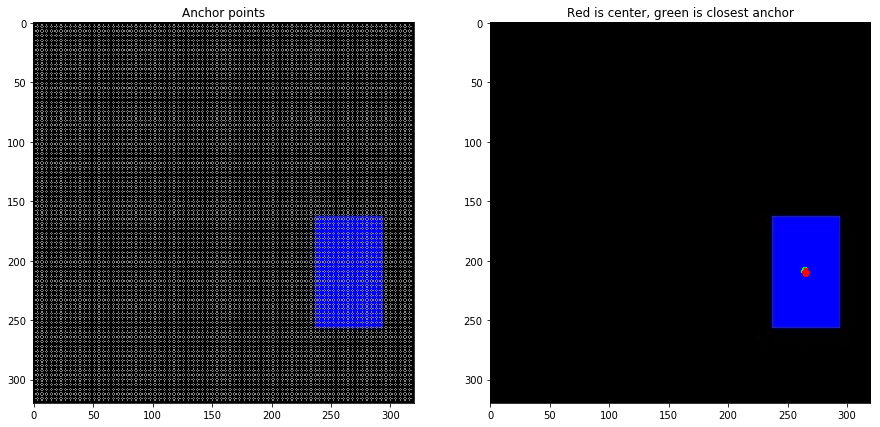

In [27]:
index = 1
im = np.copy(images[1])
im_anchors = np.copy(images[1])

print(anchs[1, 1])

# draw all anchors
for anc_x in range(ANCHOR_HEIGHT):
    for anc_y in range(ANCHOR_WIDTH):
        cv2.circle(im_anchors, (anchs[anc_x, anc_y][0], anchs[anc_x, anc_y][1]), 1, (128, 128, 128), thickness=1)



# Get labels with max value, we know this to only be one in the labels
label_indicies = np.where(labels[index, :, :, 0] == labels[index, :, :, 0].max())
print(f"Max values in labels: {len(label_indicies[0])}")

# Get location in the anchor
x_anchor, y_anchor = label_indicies
# when anchor location is known, the location of the closest anchor in the actual image can be found
x_without_offset, y_without_offset = anchs[x_anchor[0], y_anchor[0]]
"""
# The offset can then be extracted from the labels
(x_offset, y_offset) = labels[index, label_indicies[0], label_indicies[1]][0][1:]
# and the final point calculated
actual_x = int(x_without_offset + x_offset)
actual_y= int(y_without_offset + y_offset)
print(f"Actual point: ({actual_x}, {actual_y})")
"""
actual_x, actual_y = get_all_points_from_prediction(labels[index])[0]

cv2.circle(im, (y_without_offset, x_without_offset), 2, (0, 255, 0), thickness=2)
cv2.circle(im, (actual_y, actual_x), 2, (255, 0, 0), thickness=2)
print(f"Anchor: ({x_anchor}, {y_anchor})")
print(labels[index, label_indicies[0], label_indicies[1]])

f, subs = plt.subplots(1, 2, figsize=(15, 8))

subs[0].imshow(im_anchors)
subs[0].set_title("Anchor points")
subs[1].imshow(im)
subs[1].set_title("Red is center, green is closest anchor")

In [28]:
#labels = np.array(labels)#.reshape(1, 100, 2)
#print(labels.shape)
#print(labels[0])

In [29]:
#for c, i in enumerate(images):
#    model.fit(i.reshape(1, 320, 320, 3), labels[c].reshape(1, 2), epochs=1, verbose=1)

In [30]:
#model.fit(images.reshape(-1, 320, 320, 3), labels.reshape(-1, 2), batch_size=10, epochs=10, verbose=1)

In [31]:
#def loss(y_true, y_pred):
#    return K.sqrt(K.sum(K.square(y_true - y_pred)))

In [32]:
class PrintInfo(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(f"Learning rate with decay: {K.eval(lr_with_decay)}")
        #print(f"lr={K.eval(lr)}, decay={K.eval(decay)}")
        print("")
        
print_info = PrintInfo()

In [33]:
model = Model(inputs=input_layer, outputs=preds)
opt = optimizers.Adam(lr=1e-3, decay=1e-4)
#opt =optimizers.SGD()
model.compile(loss=loss, optimizer=opt)

In [34]:
#model.fit(images.reshape(-1, 320, 320, 3), labels.reshape(-1, 2), batch_size=10, epochs=10, verbose=1)
model.fit(images,#.reshape(-1, 320, 320, 3),
          labels,#.reshape(-1, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3),
          batch_size=BATCHSIZE,
          epochs=100,
          verbose=1,
          callbacks=[print_info])

Epoch 1/100
100/100 [==============================] - 8s 80ms/step - loss: 0.4664
Learning rate with decay: 0.0009987017838284373

Epoch 2/100
 88/100 [=========================>....] - ETA: 0s - loss: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
CHECK_IMAGE_INDEX = 2

In [ ]:
res = model.predict(images[CHECK_IMAGE_INDEX].reshape(1, 320, 320, 3)).reshape(ANCHOR_HEIGHT, ANCHOR_WIDTH, 3)

In [ ]:
indicies = np.where(res[:,:,0] == res[:,:,0].max())
#print(indicies)
print(f"Max values found: {len(indicies[0])}")
print(res[indicies[0][0], indicies[1][0], 0])
#print(res[indicies[0][5], indicies[1][5], 0])

In [ ]:
label_indicies = np.where(labels[CHECK_IMAGE_INDEX, :, :, 0] == labels[CHECK_IMAGE_INDEX, :, :, 0].max())
print(f"Max values in labels: {len(label_indicies[0])}")

In [ ]:
print(np.max(res[:, :, 0]))
print(np.count_nonzero(res[:, :, 0] >= 0.0))
print(np.argmax(res[:, :, 0]))

In [ ]:
# Copy the image, so we don't change anything
im_res = np.copy(images[CHECK_IMAGE_INDEX])

for x_res, y_res in get_all_points_from_prediction(res, threshold=1.0):
    cv2.circle(im_res, (y_res, x_res), 2, (0, 255, 0), thickness=5)

x_actual, y_actual = get_all_points_from_prediction(labels[CHECK_IMAGE_INDEX])[0]
cv2.circle(im_res, (y_actual, x_actual), 2, (255, 0, 0), thickness=5)
    
f = plt.figure(figsize=(15, 8))
plt.imshow(im_res)
plt.title("Predicted in green, center in red.")

In [ ]:
def ohe_encode_gt(num_data, gt):
    gt_ohe = np.zeros((num_data, num_output))
    print(gt_ohe.shape)
    
    lowest_index = [0, 0]
    for c, i in enumerate(gt):
        
        np.sqrt(np.sum(np.square(  )))
        
ohe_encode_gt(len(labels), labels)